# Combining templates and plotting systematic shifts

Author(s): Raghav Kansal, Javier Duarte

In [1]:
import pickle
import json
from pathlib import Path
from HH4b.hh_vars import years

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
templates_path = Path(
    "/home/users/cmantill/hh/HH4b/src/HH4b/postprocessing/templates/24June3NewBDTNewSamplesPtSecond250"
)

## Combining templates

In [4]:
templates = {}
year = "2023"

with (templates_path / f"{year}_templates.pkl").open("rb") as f:
    templates = pickle.load(f)

In [5]:
templates

{'pass_vbf': Hist(
   StrCategory(['data', 'hh4b', 'vbfhh4b', 'vbfhh4b-k2v0', 'qcd', 'ttbar', 'gghtobb', 'vbfhtobb', 'vhtobb', 'novhhtobb', 'tthtobb', 'diboson', 'vjets', 'hh4b_txbb_down', 'vbfhh4b_txbb_down', 'vbfhh4b-k2v0_txbb_down', 'ttbar_ttbarSF_pTjj_down', 'ttbar_ttbarSF_tau32_down', 'ttbar_ttbarSF_Xbb_bin_0_0.8_down', 'ttbar_ttbarSF_Xbb_bin_0.8_0.94_down', 'ttbar_ttbarSF_Xbb_bin_0.94_0.99_down', 'ttbar_ttbarSF_Xbb_bin_0.99_1_down', 'hh4b_txbb_up', 'vbfhh4b_txbb_up', 'vbfhh4b-k2v0_txbb_up', 'ttbar_ttbarSF_pTjj_up', 'ttbar_ttbarSF_tau32_up', 'ttbar_ttbarSF_Xbb_bin_0_0.8_up', 'ttbar_ttbarSF_Xbb_bin_0.8_0.94_up', 'ttbar_ttbarSF_Xbb_bin_0.94_0.99_up', 'ttbar_ttbarSF_Xbb_bin_0.99_1_up'], name='Sample'),
   Regular(16, 60, 220, name='H2PNetMass', label='$m^{2}_\\mathrm{reg}$ (GeV)'),
   storage=Weight()) # Sum: WeightedSum(value=43.6876, variance=11.9042),
 'pass_bin1': Hist(
   StrCategory(['data', 'hh4b', 'vbfhh4b', 'vbfhh4b-k2v0', 'qcd', 'ttbar', 'gghtobb', 'vbfhtobb', 'vhtobb', 'no

## Testing JES plots

In [6]:
import hist
from hist import Hist
import numpy as np
from HH4b.hh_vars import jecs, jmsr, bg_keys, sig_keys, LUMI
from HH4b import utils, plotting, postprocessing
from HH4b.postprocessing import datacardHelpers, Region
import warnings
from pathlib import Path

In [7]:
main_plot_dir = Path("plots/PostProcessing/24June3NewBDTNewSamplesPtSecond250/Templates")


selection_regions = {
    "pass_bin1": Region(
        cuts={
            "Category": [1, 2],
        },
        label="Bin1",
    ),
    "pass_bin2": Region(
        cuts={
            "Category": [2, 3],
        },
        label="Bin2",
    ),
    "pass_bin3": Region(
        cuts={
            "Category": [3, 4],
        },
        label="Bin3",
    ),
    "fail": Region(
        cuts={
            "Category": [4, 5],
        },
        label="Fail",
    ),
}

In [ ]:
def combine_hists(*hists):
    csamples = []
    for h in hists:
        csamples += list(h.axes[0])

    reth = Hist(
        hist.axis.StrCategory(csamples, name="Sample"),
        *hists[0].axes[1:],
        storage="weight",
    )

    for h in hists:
        for sample in h.axes[0]:
            reth.view(flow=True)[utils.get_key_index(reth, sample), ...] = h[sample, ...].view(
                flow=True
            )

    return reth

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mplhep as hep

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))

# this is needed for some reason to update the font size for the first plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plt.rcParams.update({"font.size": 24})
plt.close()

In [ ]:
warnings.filterwarnings("ignore")

# sig_key = "hh4b"
# sig_key = "vbfhh4b-k2v0"
sig_key = "ttbar"

for rname, region in selection_regions.items():
    plot_dir = main_plot_dir / year / "wshifts"
    plot_dir.mkdir(exist_ok=True, parents=True)
    # for wshift in list((jecs).keys()):
    for wshift in [
        "ttbarSF_Xbb_bin_0_0.8",
        "ttbarSF_Xbb_bin_0.8_0.94",
        "ttbarSF_Xbb_bin_0.94_0.99",
        "ttbarSF_Xbb_bin_0.99_1",
        "ttbarSF_pTjj",
        "ttbarSF_tau32",
    ]:
        if wshift in jecs:
            # adding jshift-ed histograms into the same histogram
            cjshift_templates = [templates[rname]]
            for shift in ["up", "down"]:
                # new histogram with sample names renamed to "{sample}_{jsf}_{shift}"
                jt = templates[f"{rname}_{wshift}_{shift}"]
                slabels = [f"{s}_{wshift}_{shift}" for s in jt.axes[0]]
                rjt = Hist(
                    hist.axis.StrCategory(slabels, name="Sample"),
                    *jt.axes[1:],
                    storage="weight",
                )
                rjt.view()[...] = jt.view()
                cjshift_templates.append(rjt)

                cjt = combine_hists(*cjshift_templates)
                shift_label = wshift
        else:
            shift_label = postprocessing.weight_shifts[wshift].label
            cjt = templates[rname]
        print(cjt)

        plotting.sigErrRatioPlot(
            cjt,
            sig_key,
            wshift,
            "$m_{reg}^{2}$ (GeV)",
            f"{region.label} Region {shift_label} Variations",
            plot_dir,
            f"{rname}_sig_{wshift}",
            show=True,
        )

In [11]:
from rhalphalib import MorphHistW2
from HH4b.postprocessing.datacardHelpers import smass, smorph
import hist

print(hist.__version__)

jmr_values = {
    "2022": [1.13, 1.06, 1.20],
    "2022EE": [1.20, 1.15, 1.25],
    "2023": [1.20, 1.16, 1.24],
    "2023BPix": [1.16, 1.09, 1.23],
}
jms_values = {
    "2022": [1.015, 1.010, 1.020],
    "2022EE": [1.021, 1.018, 1.024],
    "2023": [0.999, 0.996, 1.003],
    "2023BPix": [0.974, 0.970, 0.980],
}

histogram = templates["pass_bin1"]["hh4b", :]
templ = histogram

templ_nominal = smorph(templ, "hh4b", jms_values[year][0], jmr_values[year][0])
templ_jms_dn = smorph(templ, "hh4b", jms_values[year][1], jmr_values[year][0])
templ_jms_up = smorph(templ, "hh4b", jms_values[year][2], jmr_values[year][0])
templ_jmr_dn = smorph(templ, "hh4b", jms_values[year][0], jmr_values[year][1])
templ_jmr_up = smorph(templ, "hh4b", jms_values[year][0], jmr_values[year][2])

2.7.1
smorph: hh4b
smass: hh4b
smorph: hh4b
smass: hh4b
smorph: hh4b
smass: hh4b
smorph: hh4b
smass: hh4b
smorph: hh4b
smass: hh4b


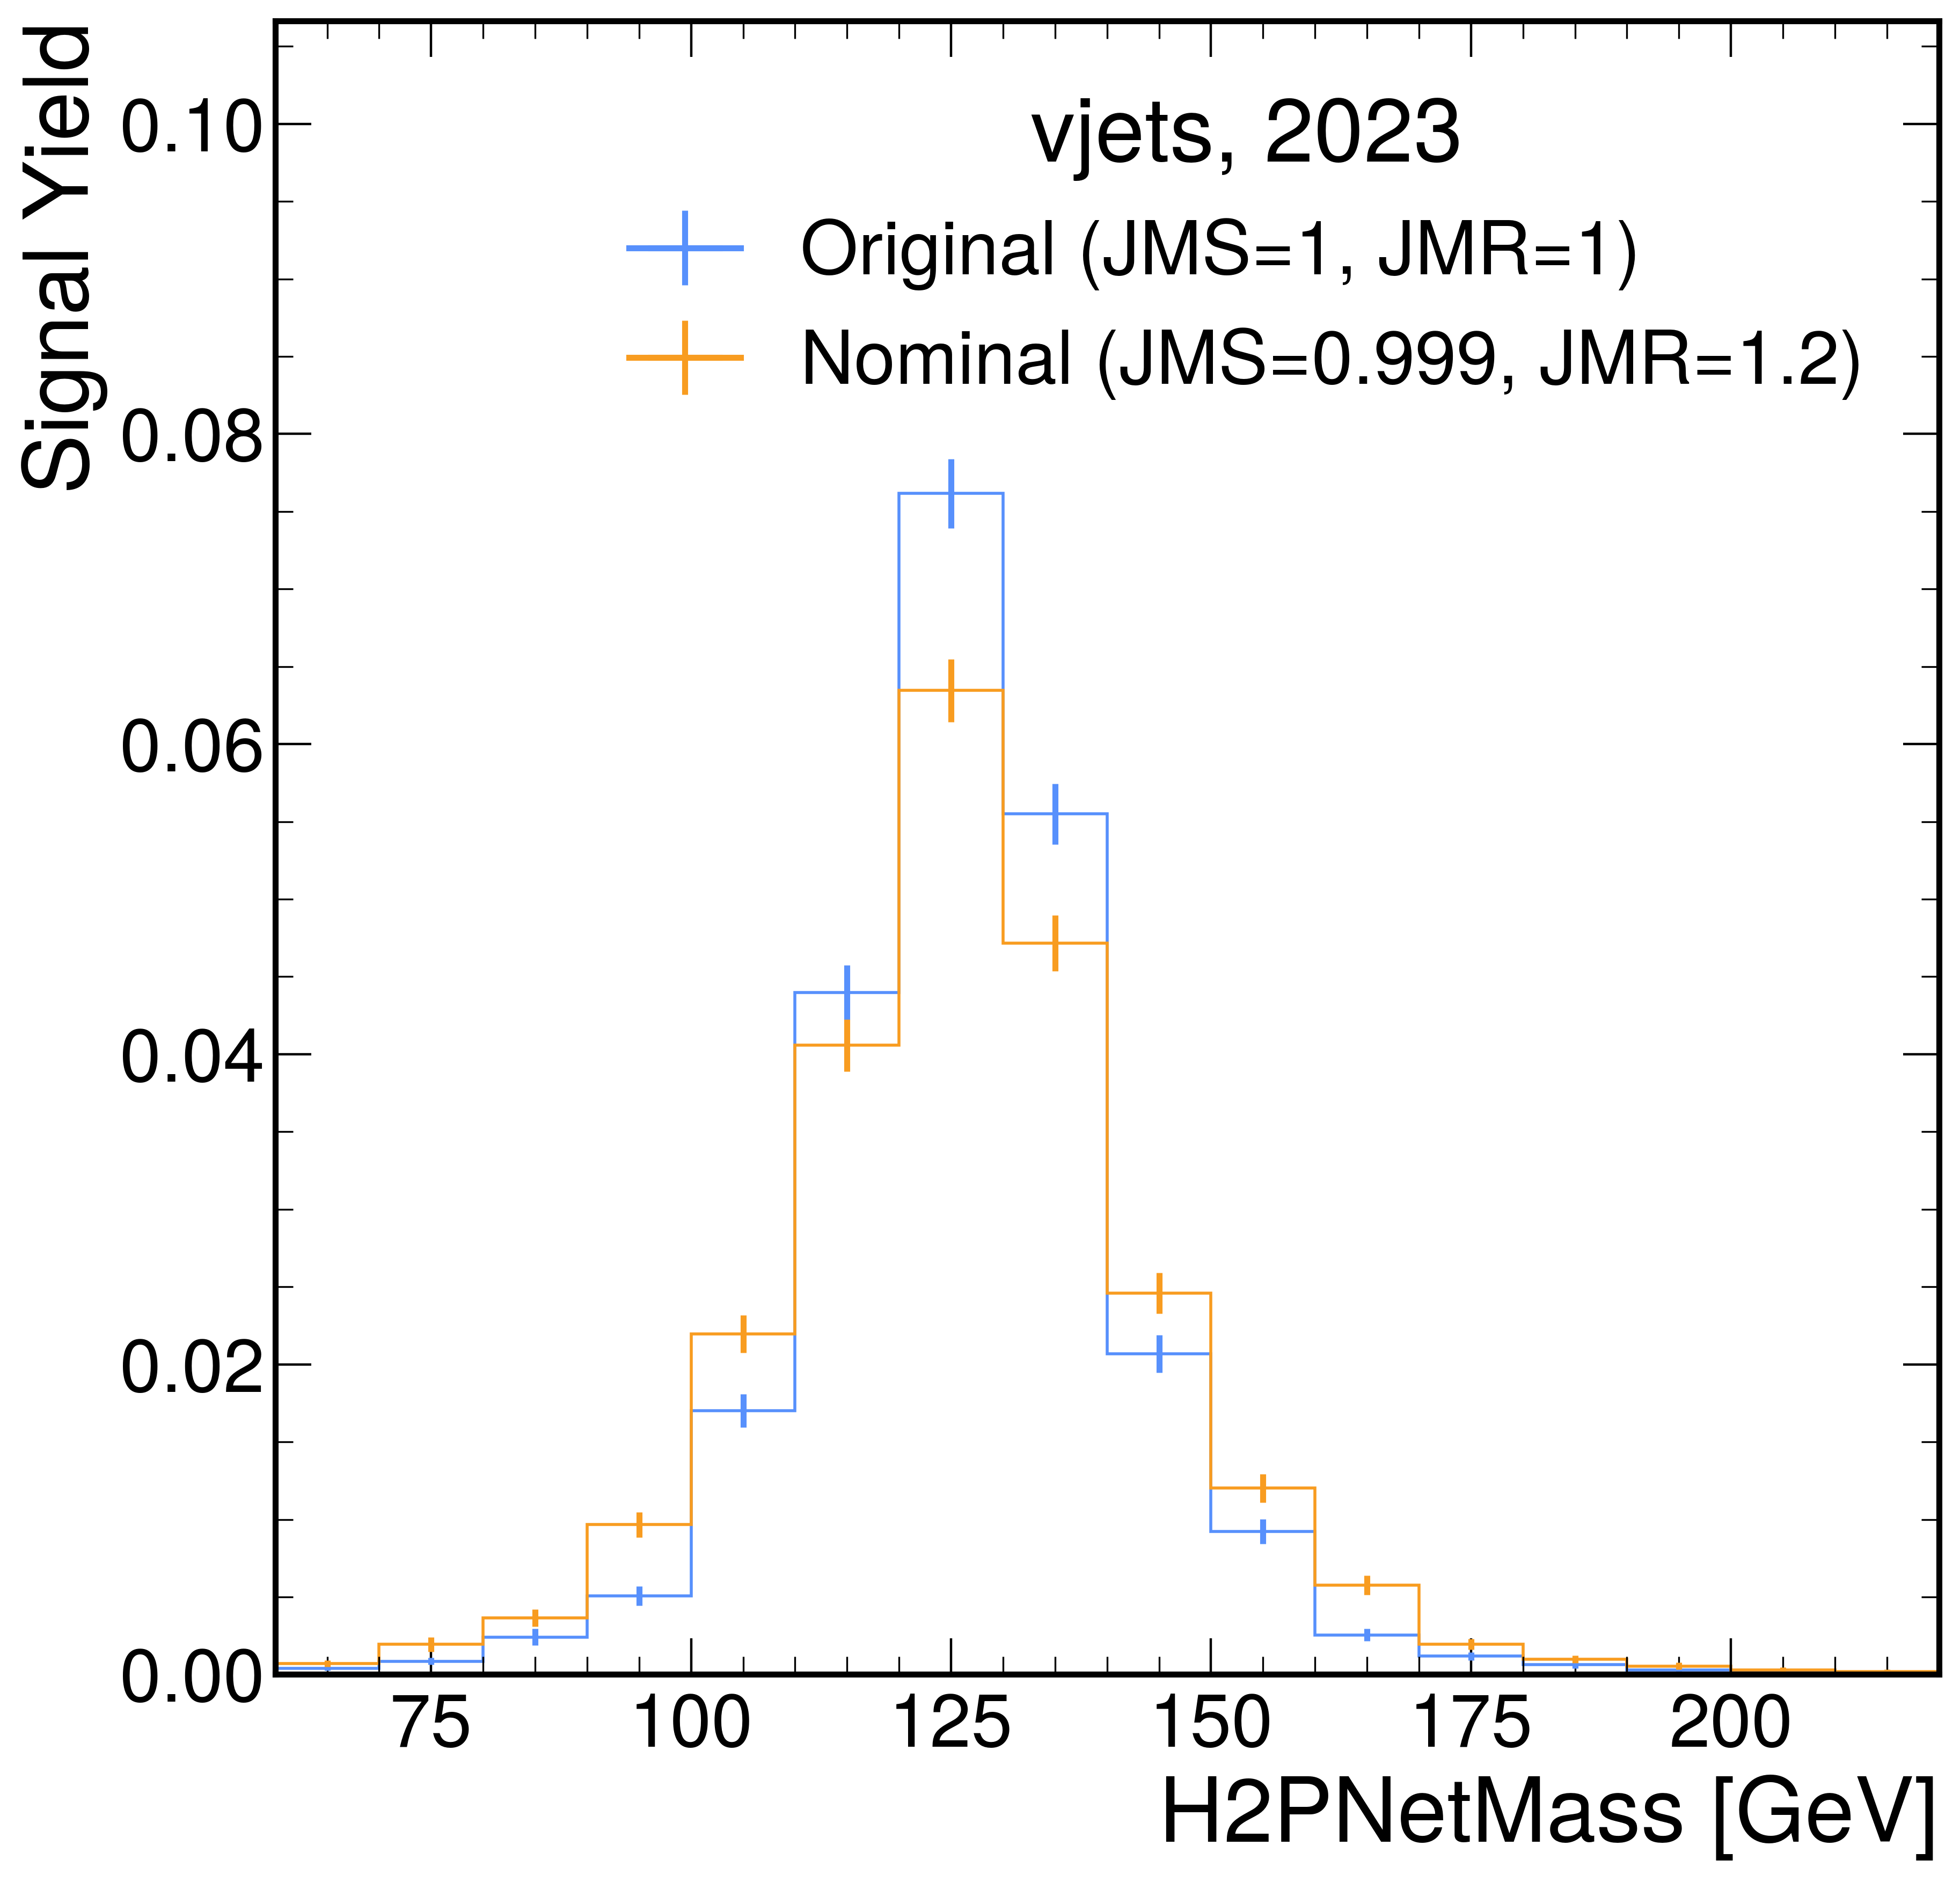

In [10]:
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

edges = templ.axes[0].edges
var_name = histogram.axes[0].name
ymax = np.max(templ.values()) * 1.4

plt.figure()
hep.histplot(
    templ.values(),
    edges,
    yerr=np.sqrt(templ.variances()),
    histtype="step",
    label="Original (JMS=1, JMR=1)",
)
hep.histplot(
    templ_nominal.values(),
    edges,
    yerr=np.sqrt(templ_nominal.variances()),
    histtype="step",
    label=f"Nominal (JMS={jms_values[year][0]}, JMR={jmr_values[year][0]})",
)
plt.legend(title=f"vjets, {year}")
plt.ylim(0, ymax)
plt.xlim(60, 220)
plt.ylabel("Signal Yield")
plt.xlabel(var_name + " [GeV]")
plt.show()

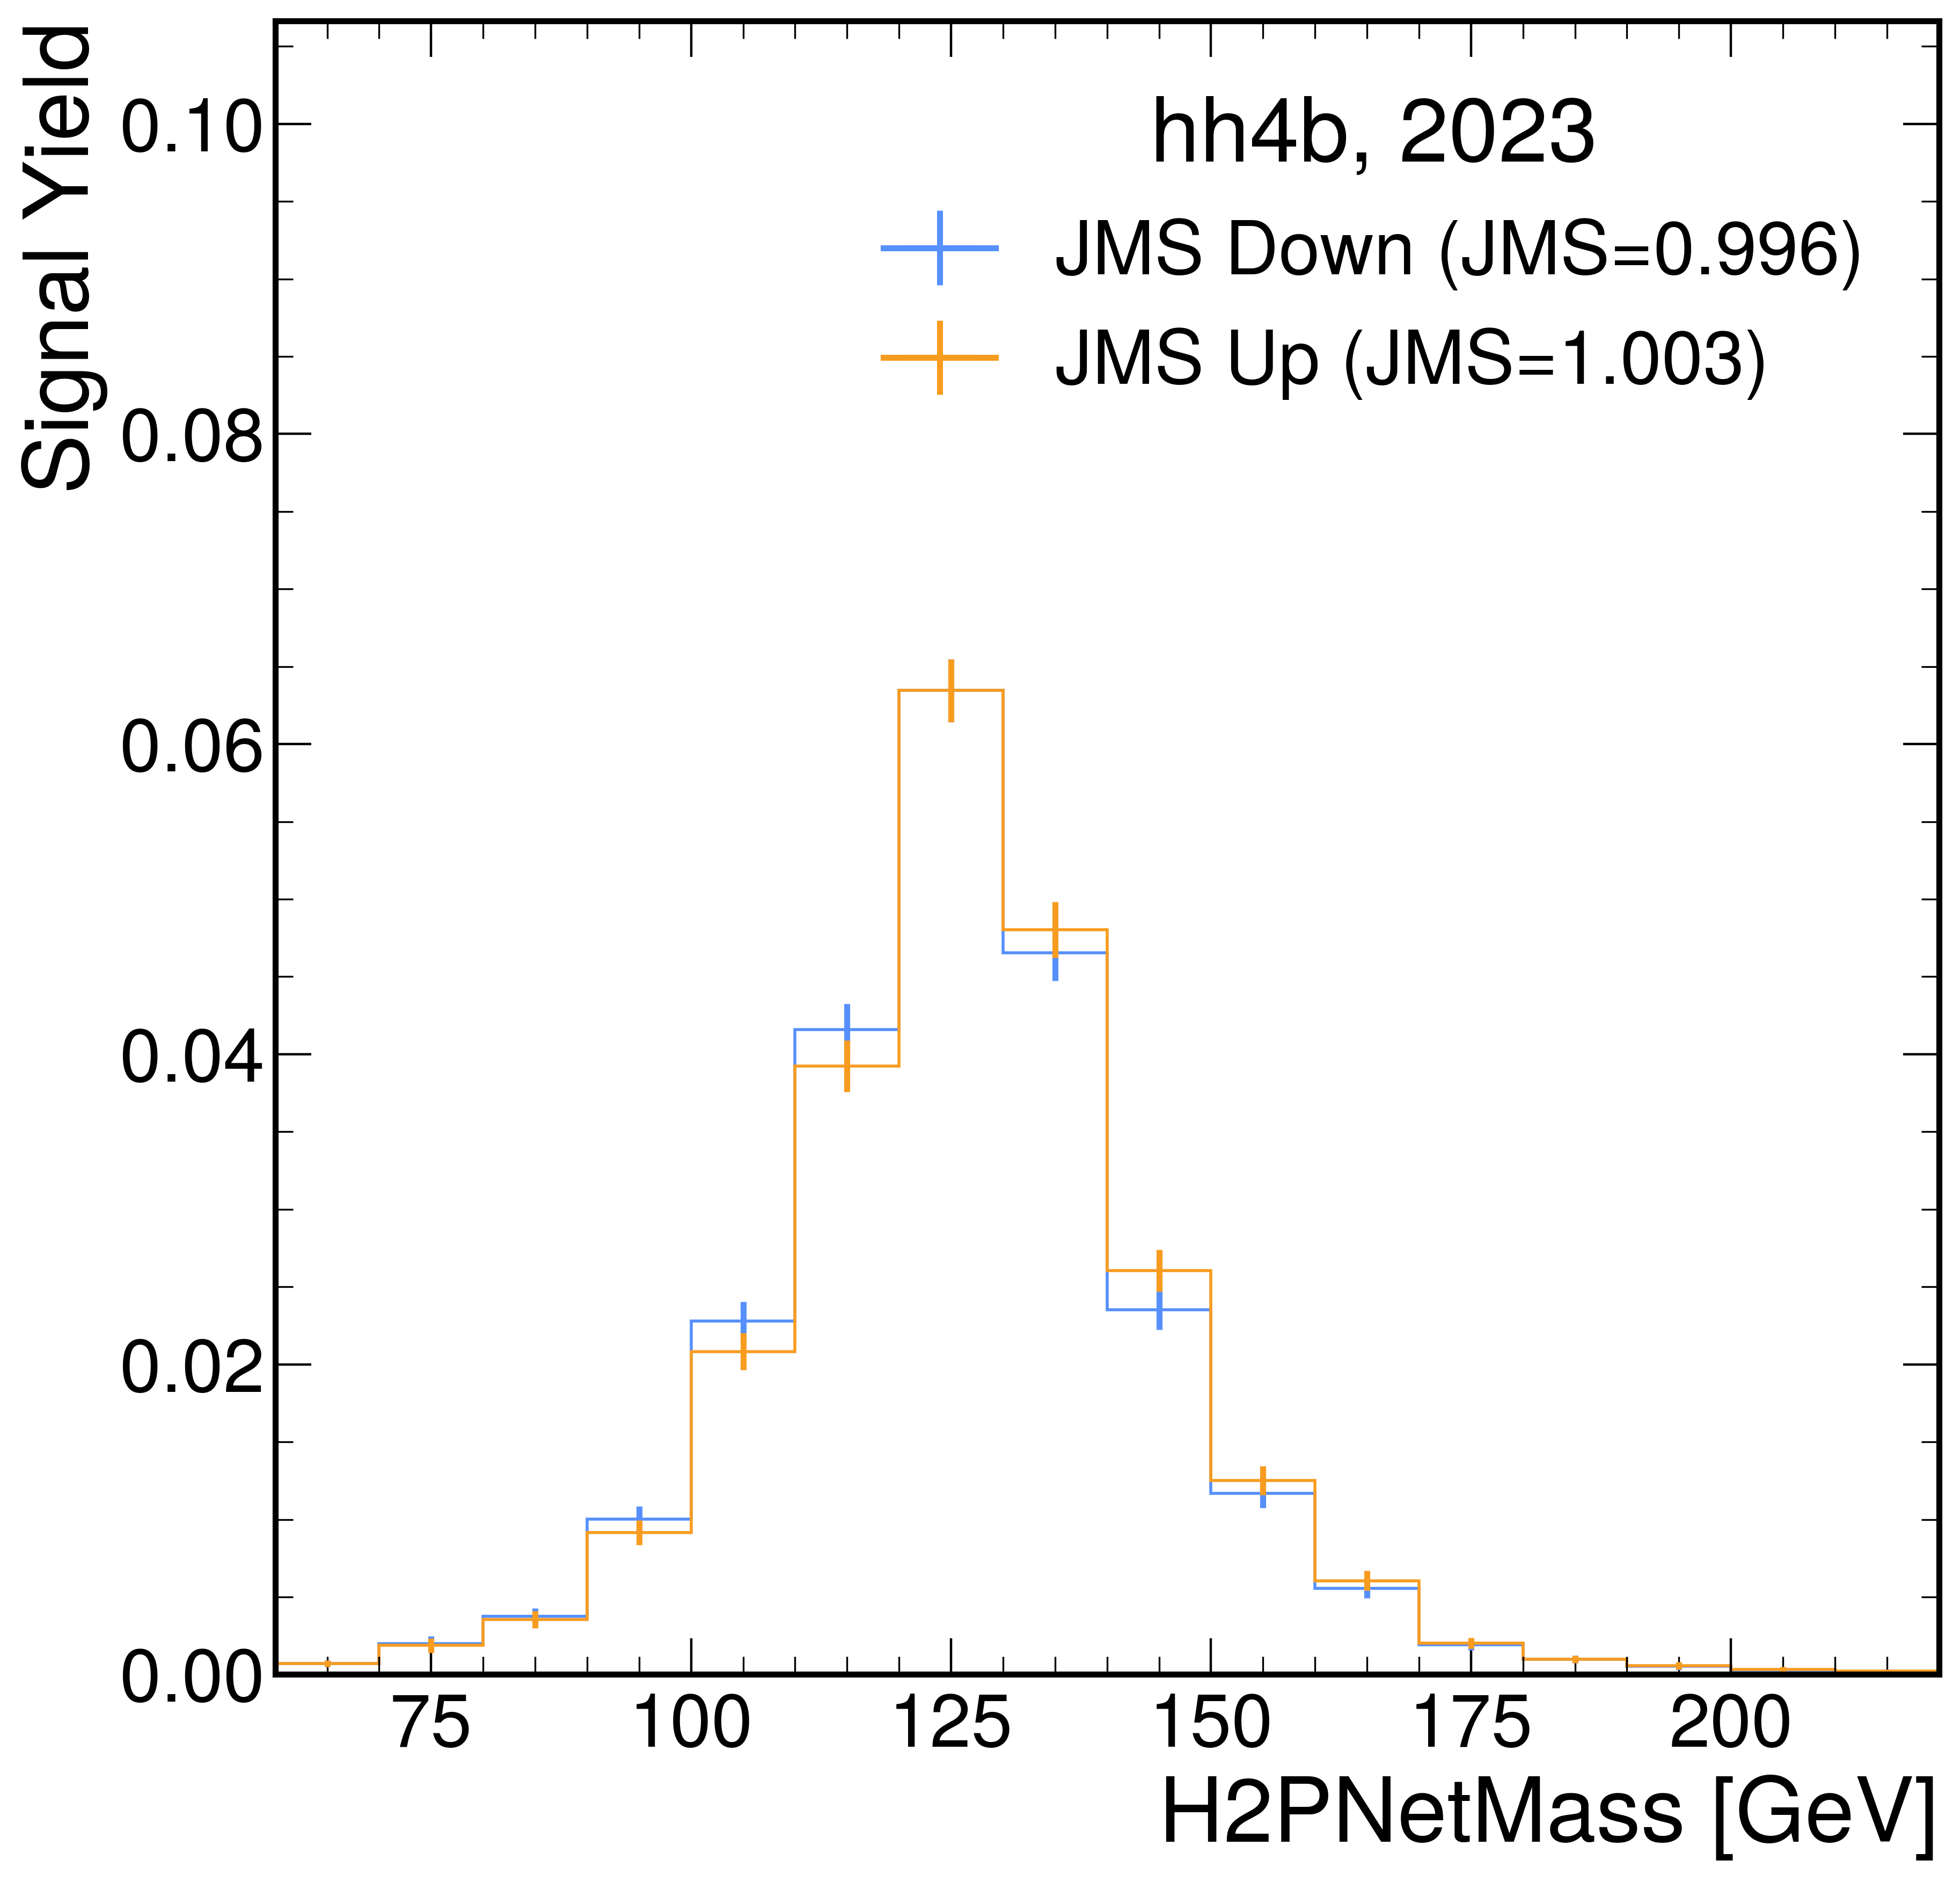

In [8]:
plt.figure()
hep.histplot(
    templ_jms_dn.values(),
    edges,
    yerr=np.sqrt(templ_jms_dn.variances()),
    histtype="step",
    label=f"JMS Down (JMS={jms_values[year][1]})",
)
hep.histplot(
    templ_jms_up.values(),
    edges,
    yerr=np.sqrt(templ_jms_up.variances()),
    histtype="step",
    label=f"JMS Up (JMS={jms_values[year][2]})",
)
plt.legend(title=f"hh4b, {year}")
plt.xlabel(templ[2])
plt.ylim(0, ymax)
plt.xlim(60, 220)
plt.ylabel("Signal Yield")
plt.xlabel(var_name + " [GeV]")
plt.show()

Text(1, 0, 'H2PNetMass [GeV]')

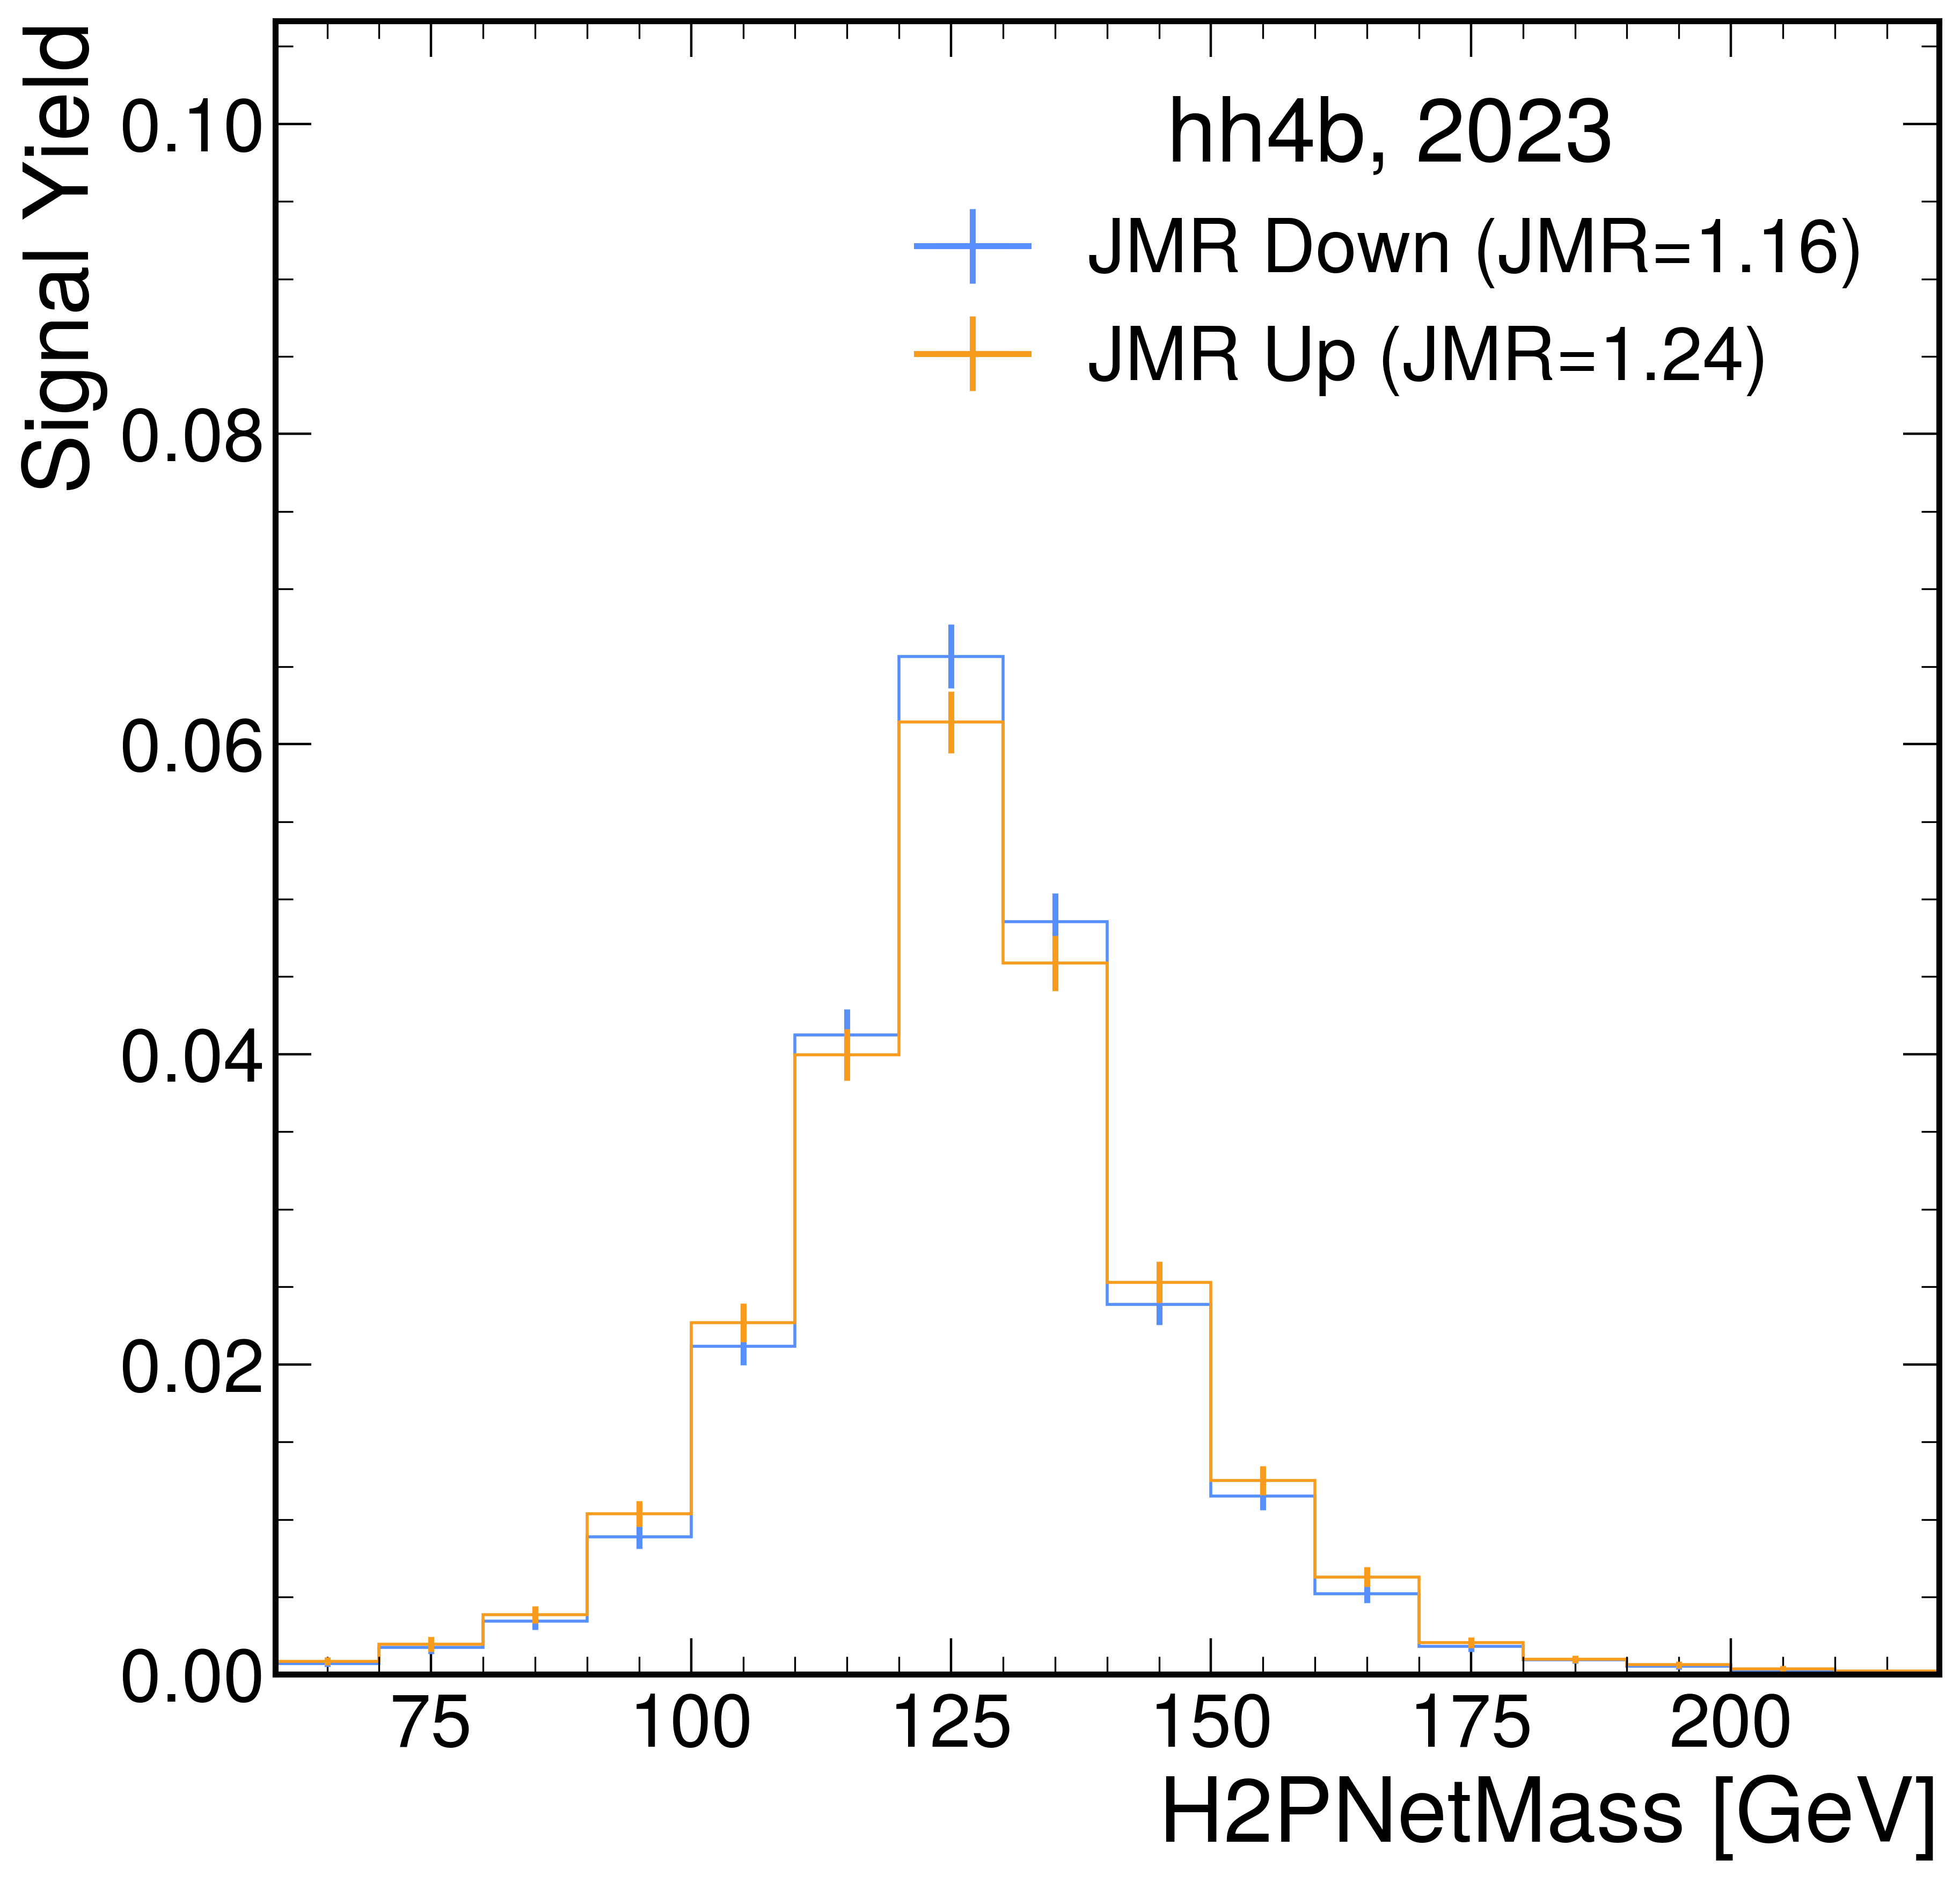

In [9]:
plt.figure()
hep.histplot(
    templ_jmr_dn.values(),
    edges,
    yerr=np.sqrt(templ_jmr_dn.variances()),
    histtype="step",
    label=f"JMR Down (JMR={jmr_values[year][1]})",
)
hep.histplot(
    templ_jmr_up.values(),
    edges,
    yerr=np.sqrt(templ_jmr_up.variances()),
    histtype="step",
    label=f"JMR Up (JMR={jmr_values[year][2]})",
)
plt.legend(title=f"hh4b, {year}")
plt.xlabel(templ[2])
plt.ylim(0, ymax)
plt.xlim(60, 220)
plt.ylabel("Signal Yield")
plt.xlabel(var_name + " [GeV]")